# ICLR acceptance prediction

In [24]:
from pathlib import Path
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

USE_TABPFN = True
TabPFNClassifier = None
if USE_TABPFN:
    try:
        from tabpfn import TabPFNClassifier
    except ImportError:
        USE_TABPFN = False
        print("TabPFN not installed; skipping TabPFN models.")

USE_AUTOGLUON = False
TabularPredictor = None
if USE_AUTOGLUON:
    try:
        from autogluon.tabular import TabularPredictor
    except ImportError:
        USE_AUTOGLUON = False
        print("AutoGluon not installed; skipping AutoGluon models.")

DATA_DIR = Path("data") / "iclr" #data from https://github.com/papercopilot/paperlists
PREDICTIONS_DIR = Path("predictions") / "iclr"
PREDICTIONS_DIR.mkdir(parents=True, exist_ok=True)

YEAR_PATHS = {
    #2023: DATA_DIR / "iclr2023.json",
    2024: DATA_DIR / "iclr2024.json",
    2025: DATA_DIR / "iclr2025.json",
    #2026: DATA_DIR / "iclr2026.json",
}

# Choose which year to evaluate. All years BEFORE this one are training data.
EVAL_YEAR = 2025

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [25]:
DROP_COLS = [
    #"id",
    "title",
    "track",
    "status",
    "tldr",
    "abstract",
    "keywords",
    "primary_area",
    "supplementary_material",
    "author",
    "authorids",
    "gender",
    "homepage",
    "dblp",
    "google_scholar",
    "orcid",
    "linkedin",
    "or_profile",
    "aff",
    "aff_domain",
    "position",
    "bibtex",
    "github",
    "project",
    "reviewers",
    "site",
    "pdf_size",
    "gs_citation",
    "gs_cited_by_link",
    "gs_version_total",
    "aff_unique_index",
    "aff_unique_norm",
    "aff_unique_dep",
    "aff_unique_url",
    "aff_unique_abbr",
    "aff_campus_unique_index",
    "aff_campus_unique",
    "aff_country_unique_index",
    "aff_country_unique",
    "author_site",
    "openreview",
    "pdf",
    "email",
    "author_num",

    "corr_recommendation_confidence",
    "corr_recommendation_correctness",
    "corr_rating_confidence",
    "poster",
]


def _adjust_2026_ratings(series: pd.Series) -> pd.Series:
    mapping = {"0": "1", "2": "3", "4": "5"}

    def transform(value: object) -> object:
        if pd.isna(value):
            return value
        parts = str(value).split(";")
        parts = [mapping.get(part, part) for part in parts]
        return ";".join(parts)

    return series.apply(transform)


def load_year_data(
    year: int,
    path: Path,
) -> tuple[pd.DataFrame, pd.Series | None, pd.Series | None]:
    df = pd.read_json(path)
    # Align 2023 schema: recommendation == rating
    if "recommendation" in df.columns:
        df = df.rename(columns={"recommendation": "rating"})
    if year == 2026 and "rating" in df.columns:
        df["rating"] = _adjust_2026_ratings(df["rating"])
    status_raw = df.get("status")
    paper_ids = df.get("id")

    id_map_path = DATA_DIR / f"iclr_id_to_number_{year}.json"
    if id_map_path.exists() and paper_ids is not None:
        with id_map_path.open("r", encoding="utf-8") as handle:
            id_map = json.load(handle)
        df["submission_number"] = pd.to_numeric(
            paper_ids.map(id_map),
            errors="coerce",
        ).astype("Int64")
        df = df.set_index("submission_number", drop=True)
        paper_ids = df.index
        if "id" in df.columns:
            df = df.drop(columns=["id"])

    drop_cols = list(DROP_COLS)
    if EVAL_YEAR == 2026:
        # 2026 has reduced reiew respose time so these values are not comparable with previous years
        drop_cols.extend(["wc_reply_reviewers", "reply_reviewers"])
    df = df.drop(columns=drop_cols, errors="ignore")
    return df, status_raw, paper_ids


raw_by_year = {}
status_by_year = {}
ids_by_year = {}

for year, path in YEAR_PATHS.items():
    raw_by_year[year], status_by_year[year], ids_by_year[year] = load_year_data(year, path)
    print(f"{year} rows:", len(raw_by_year[year]))

raw_by_year[EVAL_YEAR].head()

2024 rows: 7407
2025 rows: 11677


,id,rating,confidence,soundness,contribution,presentation,wc_summary,wc_strengths,wc_weaknesses,wc_questions,wc_review,wc_reply_reviewers,wc_reply_authors,reply_reviewers,reply_authors,rating_avg,confidence_avg,soundness_avg,contribution_avg,presentation_avg,wc_summary_avg,wc_strengths_avg,wc_weaknesses_avg,wc_questions_avg,wc_review_avg,wc_reply_reviewers_avg,wc_reply_authors_avg,reply_reviewers_avg,reply_authors_avg,replies_avg,authors#_avg
0,00SnKBGTsz,6;8;8;8,4;4;3;4,2;3;4;4,3;3;3;4,3;2;3;3,72;188;70;81,23;144;91;46,219;326;44;176,69;431;124;71,383;1089;329;374,219;39;137;22,506;536;834;893,2;1;1;1,4;2;3;3,"[7.5, 0.866025403784438]","[3.75, 0.433012701892219]","[3.25, 0.82915619758885]","[3.25, 0.433012701892219]","[2.75, 0.433012701892219]","[102.75, 49.39319285083725]","[76.0, 46.25472948791291]","[191.25, 101.04794654024396]","[173.75, 150.152214435885]","[543.75, 315.4642412382107]","[104.25, 79.47129985095248]","[692.25, 172.84150977123522]","[1.25, 0.433012701892219]","[3.0, 0.707106781186547]","[24, 0]","[4, 0]"
1,00ezkB2iZf,3;3;5;6,4;4;5;3,3;2;3;3,2;2;4;3,3;2;3;3,68;148;117;112,71;47;179;133,375;270;185;172,90;97;181;294,604;562;662;711,0;0;49;19,736;712;696;720,0;0;1;1,1;1;1;1,"[4.25, 1.299038105676658]","[4.0, 0.707106781186547]","[2.75, 0.433012701892219]","[2.75, 0.82915619758885]","[2.75, 0.433012701892219]","[111.25, 28.525208149985513]","[107.5, 51.85315805233081]","[250.5, 81.13722943261003]","[165.5, 82.3786987030021]","[634.75, 56.55694033449829]","[17.0, 20.03746490951388]","[716.0, 14.422205101855956]","[0.5, 0.5]","[1.0, 0.0]","[12, 0]","[7, 0]"
2,01wMplF8TL,3;5;5;5,3;4;3;3,2;2;2;3,2;2;3;3,1;3;3;2,73;44;40;78,34;54;77;101,225;234;107;152,126;102;4;75,458;434;228;406,141;180;169;256,1461;1062;1162;1232,1;1;1;1,4;3;4;4,"[4.5, 0.866025403784438]","[3.25, 0.433012701892219]","[2.25, 0.433012701892219]","[2.5, 0.5]","[2.25, 0.82915619758885]","[58.75, 16.90229274388537]","[66.5, 25.064915718988566]","[179.5, 52.566624392289064]","[76.75, 45.71309987301233]","[381.5, 90.51381110084803]","[186.5, 42.57052971246658]","[1229.25, 146.808335934987]","[1.0, 0.0]","[3.75, 0.433012701892219]","[26, 0]","[2, 0]"
3,029hDSVoXK,6;6;6;8;8,3;3;3;4;5,3;3;3;2;2,3;2;3;4;2,2;2;3;3;2,163;61;77;109;202,167;56;36;64;98,286;469;188;259;700,120;101;29;64;203,736;687;330;496;1203,0;0;0;0;0,0;0;0;0;0,0;0;0;0;0,0;0;0;0;0,"[6.8, 0.9797958971132711]","[3.6, 0.8]","[2.6, 0.48989794855663504]","[2.8, 0.7483314773547881]","[2.4, 0.48989794855663504]","[122.4, 52.905954296279354]","[84.2, 45.98434516223973]","[380.4, 184.7491271968558]","[103.4, 58.803401262171896]","[690.4, 294.118751527338]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[7, 0]","[6, 0]"
4,02DCEU6vSU,3;3;5;5;8,4;4;4;3;4,2;2;2;3;3,2;2;3;2;3,3;3;3;3;3,90;112;59;95;112,76;112;95;29;54,200;192;399;32;39,227;111;3;635;80,593;527;556;791;285,0;0;0;0;0,0;0;0;0;0,0;0;0;0;0,0;0;0;0;0,"[4.8, 1.8330302779823362]","[3.8, 0.399999999999999]","[2.4, 0.48989794855663504]","[2.4, 0.48989794855663504]","[3.0, 0.0]","[93.6, 19.4381069037085]","[73.2, 29.362561196189954]","[172.4, 134.16497307419698]","[211.2, 223.81099168718234]","[550.4, 161.6905686798089]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[6, 0]","[3, 0]"


In [26]:
raw_by_year[2024].head()

,id,rating,confidence,soundness,contribution,presentation,wc_summary,wc_strengths,wc_weaknesses,wc_questions,wc_review,wc_reply_reviewers,wc_reply_authors,reply_reviewers,reply_authors,rating_avg,confidence_avg,soundness_avg,contribution_avg,presentation_avg,wc_summary_avg,wc_strengths_avg,wc_weaknesses_avg,wc_questions_avg,wc_review_avg,wc_reply_reviewers_avg,wc_reply_authors_avg,reply_reviewers_avg,reply_authors_avg,replies_avg,authors#_avg
0,0074qaufB6,1;3;5,4;3;4,2;3;2,1;2;2,2;2;3,97;80;124,49;53;168,350;172;196,48;41;182,544;346;670,0;0;0,0;0;0,0;0;0,0;0;0,"[3.0, 1.632993161855452]","[3.666666666666666, 0.471404520791031]","[2.333333333333333, 0.471404520791031]","[1.666666666666666, 0.471404520791031]","[2.333333333333333, 0.471404520791031]","[100.33333333333333, 18.116904322268255]","[90.0, 55.17849822772152]","[239.33333333333334, 78.86415887813396]","[90.33333333333333, 64.88108781112996]","[520.0, 133.3566646253572]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[3, 0]","[2, 0]"
1,014CgNPAGy,3;5;5;6,4;5;4;3,1;1;3;3,1;1;2;3,2;3;3;3,47;156;94;104,31;8;15;95,219;937;242;65,6;53;5;6,303;1154;356;270,198;899;68;10,514;2139;1249;161,1;2;1;1,1;4;3;1,"[4.75, 1.089724735885168]","[4.0, 0.707106781186547]","[2.0, 1.0]","[1.75, 0.82915619758885]","[2.75, 0.433012701892219]","[100.25, 38.71934271136327]","[37.25, 34.368408458932166]","[365.75, 336.7590941607962]","[17.5, 20.5]","[520.75, 366.8919289109533]","[293.75, 356.01009466024976]","[1015.75, 758.0314554818949]","[1.25, 0.433012701892219]","[2.25, 1.299038105676658]","[20, 0]","[2, 0]"
2,01Yi8rzoNs,3;3;5;6,4;4;4;4,2;2;2;3,2;2;2;3,2;3;2;3,136;55;76;74,27;31;117;55,285;261;411;235,4;21;109;52,452;368;713;416,0;0;0;0,0;0;0;0,0;0;0;0,0;0;0;0,"[4.25, 1.299038105676658]","[4.0, 0.0]","[2.25, 0.433012701892219]","[2.25, 0.433012701892219]","[2.5, 0.5]","[85.25, 30.425112982534674]","[57.5, 35.98263470064414]","[298.0, 67.59437846448475]","[46.5, 39.978119015281344]","[487.25, 133.69999065071022]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[4, 0]","[10, 0]"
3,01ep65umEr,5;5;5;6,3;4;3;5,2;3;2;2,2;3;2;3,2;3;2;3,96;37;46;90,104;13;59;51,196;184;86;250,1;4;98;6,397;238;289;397,0;0;0;86,499;672;771;668,0;0;0;1,1;1;1;1,"[5.25, 0.433012701892219]","[3.75, 0.82915619758885]","[2.25, 0.433012701892219]","[2.5, 0.5]","[2.5, 0.5]","[67.25, 26.03243169586737]","[56.75, 32.34482184214345]","[179.0, 59.16924876994806]","[27.25, 40.88627520330019]","[330.25, 69.14251586397475]","[21.5, 37.239092362730865]","[652.5, 97.75607398008576]","[0.25, 0.433012701892219]","[1.0, 0.0]","[12, 0]","[4, 0]"
4,02Ug9N8DCI,3;3;3;5,4;4;4;5,2;1;1;3,1;2;3;2,2;2;2;2,110;38;40;104,72;15;38;94,275;9;167;159,2;310;33;278,459;372;278;635,0;0;0;0,0;0;0;0,0;0;0;0,0;0;0;0,"[3.5, 0.866025403784438]","[4.25, 0.433012701892219]","[1.75, 0.82915619758885]","[2.0, 0.707106781186547]","[2.0, 0.0]","[73.0, 34.07345007480164]","[54.75, 30.408674749156695]","[152.5, 94.67180150393253]","[155.75, 139.1444842600669]","[436.0, 131.51996046228115]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[6, 0]","[1, 0]"


In [27]:
import re


def normalize_status(value: object) -> str | float:
    if pd.isna(value):
        return np.nan
    text = str(value).lower()
    if "top-5" in text:
        return "oral"
    if "top-25" in text:
        return "spotlight"
    if "accept" in text:
        return "accept"
    if "withdraw" in text:
        return "reject"
    if "reject" in text:
        return "reject"
    return text


def expand_multivalue_columns(df: pd.DataFrame, sep: str = ";", max_len: int = 8) -> pd.DataFrame:
    df = df.copy()
    multivalue_cols = []
    for col in df.columns:
        if df[col].dtype == "object":
            if df[col].fillna("").astype(str).str.contains(sep).any():
                multivalue_cols.append(col)

    new_cols = {}
    for col in multivalue_cols:
        parts = df[col].fillna("").astype(str).str.split(sep)
        for i in range(max_len):
            new_col = f"{col}_{i + 1}"
            values = parts.str[i].replace("", np.nan)
            new_cols[new_col] = pd.to_numeric(values, errors="coerce")

    if new_cols:
        df = pd.concat([df.drop(columns=multivalue_cols), pd.DataFrame(new_cols, index=df.index)], axis=1)
    else:
        df = df.drop(columns=multivalue_cols, errors="ignore")

    return df


def _group_numbered_columns(columns: pd.Index) -> dict[str, list[str]]:
    groups: dict[str, list[str]] = {}
    for col in columns:
        match = re.match(r"^(.*)_(\d+)$", col)
        if match:
            base = match.group(1)
            groups.setdefault(base, []).append(col)
    for base, cols in groups.items():
        groups[base] = sorted(cols, key=lambda name: int(name.rsplit("_", 1)[1]))
    return groups


def add_multivalue_summary_stats(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    groups = _group_numbered_columns(df.columns)
    for base, cols in groups.items():
        if len(cols) < 2:
            continue
        values = df[cols].apply(pd.to_numeric, errors="coerce")
        df[f"{base}_mean"] = values.mean(axis=1, skipna=True)
        df[f"{base}_std"] = values.std(axis=1, ddof=0, skipna=True)
        if base == "rating":
            df[f"{base}_count"] = values.notna().sum(axis=1)

    confidence_cols = groups.get("confidence", [])
    if confidence_cols:
        confidence_values = df[confidence_cols].apply(pd.to_numeric, errors="coerce")
        for base in ["rating", "correctness", "soundness", "contribution", "presentation"]:
            base_cols = groups.get(base, [])
            if not base_cols:
                continue
            pair_len = min(len(base_cols), confidence_values.shape[1])
            if pair_len == 0:
                continue
            base_values = df[base_cols[:pair_len]].apply(pd.to_numeric, errors="coerce")
            weighted = base_values.mul(confidence_values.iloc[:, :pair_len].to_numpy())
            mean = weighted.mean(axis=1, skipna=True)
            df[f"{base}_confidence_weighted_mean"] = mean

    return df


def _format_count_value(value: float) -> str:
    if isinstance(value, (int, np.integer)):
        return str(int(value))
    if isinstance(value, float) and float(value).is_integer():
        return str(int(value))
    return str(value).replace(".", "_")


def add_multivalue_value_counts(
    df: pd.DataFrame,
    base_names: list[str],
) -> pd.DataFrame:
    df = df.copy()
    groups = _group_numbered_columns(df.columns)
    for base in base_names:
        cols = groups.get(base, [])
        if not cols:
            continue
        values = df[cols].apply(pd.to_numeric, errors="coerce")
        stacked = values.stack(future_stack=True)
        if stacked.empty:
            continue
        unique_vals = sorted(stacked.unique())
        denom = None
        if "rating_count" in df.columns:
            denom = df["rating_count"].replace(0, np.nan)
        for val in unique_vals:
            label = _format_count_value(val)
            counts = (values == val).sum(axis=1)
            if denom is not None:
                counts = counts / denom
            df[f"{base}_count_{label}"] = counts
    return df


def add_year_mean_deltas(
    df: pd.DataFrame,
    year: int | None,
    mean_suffix: str = "_mean",
) -> pd.DataFrame:
    if year is None:
        return df
    df = df.copy()
    mean_cols = [col for col in df.columns if col.endswith(mean_suffix)]
    if not mean_cols:
        return df
    year_means = df[mean_cols].mean(skipna=True)
    for col in mean_cols:
        df[f"{col}_year_delta"] = df[col] - year_means[col]
    return df


def keep_numeric_columns(
    df: pd.DataFrame,
    drop_cols: list[str] | None = None,
    min_numeric_ratio: float = 0.8,
) -> pd.DataFrame:
    drop_cols = set(drop_cols or [])
    df = df.copy()

    numeric_df = df.select_dtypes(include=[np.number]).copy()

    for col in df.columns:
        if col in drop_cols or col in numeric_df.columns:
            continue
        if df[col].dtype == "object" and col not in ["status_norm", "poster"]:
            coerced = pd.to_numeric(df[col], errors="coerce")
            ratio = coerced.notna().mean()
            if ratio >= min_numeric_ratio:
                numeric_df[col] = coerced

    return numeric_df


def drop_constant_or_nan_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    nunique = df.nunique(dropna=True)
    keep_cols = nunique[nunique > 1].index
    return df.loc[:, keep_cols]


def drop_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    duplicate_mask = df.T.duplicated()
    if duplicate_mask.any():
        df = df.loc[:, ~duplicate_mask]
    return df


def drop_perfectly_correlated_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.shape[1] < 2:
        return df
    corr = numeric_df.corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if (upper[col].abs() > 0.999).any()]
    if to_drop:
        df = df.drop(columns=to_drop, errors="ignore")
    return df


def align_train_eval_columns(
    X_train: pd.DataFrame,
    X_eval: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    common_cols = X_train.columns.intersection(X_eval.columns)
    X_train = X_train.loc[:, common_cols]
    X_eval = X_eval.loc[:, common_cols]
    X_train = drop_constant_or_nan_columns(X_train)
    X_train = drop_duplicate_columns(X_train)
    X_train = drop_perfectly_correlated_columns(X_train)
    X_eval = X_eval.reindex(columns=X_train.columns)
    return X_train, X_eval


def apply_ranked_acceptance_tiers(
    results_df: pd.DataFrame,
    proba_cols: list[str],
    top_oral: float = 0.05,
    top_spotlight: float = 0.25,
) -> tuple[pd.Series, pd.Series]:
    if results_df.empty:
        return pd.Series(dtype=object), pd.Series(dtype=float)

    non_reject_cols = [col for col in proba_cols if col != "proba_reject"]
    if non_reject_cols:
        accept_score = results_df[non_reject_cols].sum(axis=1)
    else:
        accept_score = results_df[proba_cols].max(axis=1)

    ranked = np.where(results_df["pred_status"] == "reject", "reject", "poster")
    ranked = pd.Series(ranked, index=results_df.index)

    order = accept_score.sort_values(ascending=False).index
    n = len(results_df)
    n_oral = max(1, int(np.ceil(n * top_oral)))
    n_spotlight = max(n_oral, int(np.ceil(n * top_spotlight)))

    ranked.loc[order[:n_oral]] = "oral"
    ranked.loc[order[n_oral:n_spotlight]] = "spotlight"

    return ranked, accept_score

In [28]:
def prepare_features(
    df: pd.DataFrame,
    status_raw: pd.Series | None = None,
    year: int | None = None,
) -> tuple[pd.DataFrame, pd.Series | None]:
    df = df.copy()
    if status_raw is not None:
        df = df.assign(status_norm=status_raw.apply(normalize_status))
    expanded = expand_multivalue_columns(df)
    expanded = add_multivalue_summary_stats(expanded)
    expanded = add_multivalue_value_counts(
        expanded,
        base_names=[
            "rating",
            "confidence",
            "correctness",
            "soundness",
            "contribution",
            "presentation",
        ],
    )
    X = keep_numeric_columns(expanded, drop_cols=["status_norm"])
    X = add_year_mean_deltas(X, year)
    y_out = expanded["status_norm"] if status_raw is not None else None
    drop_prefixes = [
        "rating",
        "confidence",
        "wc_review",
        "wc_reply_authors",
        "reply_authors",
        "soundness",
        "contribution",
        "presentation",
        "wc_summary",
        "wc_strengths",
        "wc_weaknesses",
        "wc_questions",
    ]
    drop_cols = []
    drop_cols += [
        f"{prefix}_{i}" for prefix in drop_prefixes for i in range(1, 9)
    ]
    if drop_cols:
        X = X.drop(columns=drop_cols, errors="ignore")
    return X, y_out


train_years = [year for year in sorted(YEAR_PATHS) if year < EVAL_YEAR]
if not train_years:
    raise ValueError("EVAL_YEAR must be greater than the minimum year.")

train_frames = []
train_labels = []
for year in train_years:
    X_year, y_year = prepare_features(
        raw_by_year[year],
        status_by_year[year],
        year=year,
    )
    mask = y_year.notna()
    train_frames.append(X_year.loc[mask])
    train_labels.append(y_year.loc[mask])

X_train_full = pd.concat(train_frames, axis=0, ignore_index=True)
y = pd.concat(train_labels, axis=0, ignore_index=True)

X_eval, y_eval = prepare_features(
    raw_by_year[EVAL_YEAR],
    status_by_year[EVAL_YEAR],
    year=EVAL_YEAR,
)
X_train_full, X_eval = align_train_eval_columns(X_train_full, X_eval)

print("Training years:", train_years)
print("Eval year:", EVAL_YEAR)
print("Features:", X_train_full.shape[1])
print("Classes:", y.value_counts())

Training years: [2024]
Eval year: 2025
Features: 70
Classes: status_norm
reject       5147
poster       1807
spotlight     367
oral           86
Name: count, dtype: int64


In [29]:
display(X_train_full)

,wc_reply_reviewers_1,wc_reply_reviewers_2,wc_reply_reviewers_3,wc_reply_reviewers_4,wc_reply_reviewers_5,wc_reply_reviewers_6,wc_reply_reviewers_7,wc_reply_reviewers_8,reply_reviewers_1,reply_reviewers_2,reply_reviewers_3,reply_reviewers_4,reply_reviewers_5,reply_reviewers_6,reply_reviewers_7,rating_mean,rating_std,rating_count,confidence_mean,confidence_std,soundness_mean,soundness_std,contribution_mean,contribution_std,presentation_mean,presentation_std,wc_summary_mean,wc_summary_std,wc_strengths_mean,wc_strengths_std,wc_weaknesses_mean,wc_weaknesses_std,wc_questions_mean,wc_questions_std,wc_review_mean,wc_review_std,wc_reply_reviewers_mean,wc_reply_authors_mean,wc_reply_authors_std,reply_reviewers_mean,reply_reviewers_std,reply_authors_mean,reply_authors_std,rating_confidence_weighted_mean,soundness_confidence_weighted_mean,contribution_confidence_weighted_mean,presentation_confidence_weighted_mean,rating_count_1,rating_count_3,rating_count_5,rating_count_6,rating_count_8,rating_count_10,confidence_count_3,confidence_count_4,confidence_count_1,confidence_count_2,confidence_count_5,soundness_count_2,soundness_count_3,soundness_count_1,soundness_count_4,contribution_count_1,contribution_count_2,contribution_count_3,contribution_count_4,presentation_count_2,presentation_count_3,presentation_count_1,presentation_count_4
0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,3.000000,1.632993,3,3.666667,0.471405,2.333333,0.471405,1.666667,0.471405,2.333333,0.471405,100.333333,18.116904,90.000000,55.178498,239.333333,78.864159,90.333333,64.881088,520.000000,133.356665,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,11.000000,8.333333,6.000000,8.666667,0.333333,0.333333,0.333333,0.000000,0.000000,0.0,0.333333,0.666667,0.0,0.000000,0.00,0.666667,0.333333,0.000000,0.0,0.333333,0.666667,0.000000,0.0,0.666667,0.333333,0.00,0.00
1,198.0,899.0,68.0,10.0,NaN,NaN,NaN,NaN,1.0,2.0,1.0,1.0,NaN,NaN,NaN,4.750000,1.089725,4,4.000000,0.707107,2.000000,1.000000,1.750000,0.829156,2.750000,0.433013,100.250000,38.719343,37.250000,34.368408,365.750000,336.759094,17.500000,20.500000,520.750000,366.891929,293.750000,1015.750000,758.031455,1.250000,0.433013,2.25,1.299038,18.750000,7.500000,6.500000,11.000000,0.000000,0.250000,0.500000,0.250000,0.000000,0.0,0.250000,0.500000,0.0,0.000000,0.25,0.000000,0.500000,0.500000,0.0,0.500000,0.250000,0.250000,0.0,0.250000,0.750000,0.00,0.00
2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4.250000,1.299038,4,4.000000,0.000000,2.250000,0.433013,2.250000,0.433013,2.500000,0.500000,85.250000,30.425113,57.500000,35.982635,298.000000,67.594378,46.500000,39.978119,487.250000,133.699991,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,17.000000,9.000000,9.000000,10.000000,0.000000,0.500000,0.250000,0.250000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.00,0.750000,0.250000,0.000000,0.0,0.000000,0.750000,0.250000,0.0,0.500000,0.500000,0.00,0.00
3,0.0,0.0,0.0,86.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,NaN,5.250000,0.433013,4,3.750000,0.829156,2.250000,0.433013,2.500000,0.500000,2.500000,0.500000,67.250000,26.032432,56.750000,32.344822,179.000000,59.169249,27.250000,40.886275,330.250000,69.142516,21.500000,652.500000,97.756074,0.250000,0.433013,1.00,0.000000,20.000000,8.500000,9.750000,9.750000,0.000000,0.000000,0.750000,0.250000,0.000000,0.0,0.500000,0.250000,0.0,0.000000,0.25,0.750000,0.250000,0.000000,0.0,0.000000,0.500000,0.500000,0.0,0.500000,0.500000,0.00,0.00
4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,3.500000,0.866025,4,4.250000,0.433013,1.750000,0.829156,2.000000,0.707107,2.000000,0.000000,73.000000,34.073450,54.750000,30.408675,152.500000,94.671802,155.750000,139.144484,436.000000,131.519960,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,15.250000,7.750000,8.500000,8.500000,0.000000,0.750000,0.250000,0.000000,0.000000,0.0,0.000000,0.750000,0.0,0.000000,0.25,0.250000,0.250000,0.500000,0.0,0.250000,0.500000,0.250000,0.0,1.000000,0.000000,0.00

In [30]:
X_train_full.columns

Index(['wc_reply_reviewers_1', 'wc_reply_reviewers_2', 'wc_reply_reviewers_3', 'wc_reply_reviewers_4', 'wc_reply_reviewers_5', 'wc_reply_reviewers_6', 'wc_reply_reviewers_7', 'wc_reply_reviewers_8',
       'reply_reviewers_1', 'reply_reviewers_2', 'reply_reviewers_3', 'reply_reviewers_4', 'reply_reviewers_5', 'reply_reviewers_6', 'reply_reviewers_7', 'rating_mean', 'rating_std', 'rating_count',
       'confidence_mean', 'confidence_std', 'soundness_mean', 'soundness_std', 'contribution_mean', 'contribution_std', 'presentation_mean', 'presentation_std', 'wc_summary_mean', 'wc_summary_std',
       'wc_strengths_mean', 'wc_strengths_std', 'wc_weaknesses_mean', 'wc_weaknesses_std', 'wc_questions_mean', 'wc_questions_std', 'wc_review_mean', 'wc_review_std', 'wc_reply_reviewers_mean',
       'wc_reply_authors_mean', 'wc_reply_authors_std', 'reply_reviewers_mean', 'reply_reviewers_std', 'reply_authors_mean', 'reply_authors_std', 'rating_confidence_weighted_mean',
       'soundness_confidence_

In [31]:
def _safe_correlations(X: pd.DataFrame, y_bin: pd.Series) -> pd.Series:
    y_values = y_bin.to_numpy(dtype=float)
    y_std = np.nanstd(y_values)
    if y_std == 0:
        return pd.Series(dtype=float)
    corrs = {}
    for col in X.columns:
        x_values = X[col].to_numpy(dtype=float)
        mask = ~np.isnan(x_values)
        if mask.sum() < 2:
            continue
        x = x_values[mask]
        y = y_values[mask]
        x_std = np.nanstd(x)
        if x_std == 0:
            continue
        cov = np.nanmean((x - np.nanmean(x)) * (y - np.nanmean(y)))
        corrs[col] = cov / (x_std * y_std)
    return pd.Series(corrs)


def top_class_correlations(
    X: pd.DataFrame,
    y: pd.Series,
    top_n: int = 10,
) -> dict[str, dict[str, pd.DataFrame]]:
    results: dict[str, dict[str, pd.DataFrame]] = {}
    X_numeric = X.select_dtypes(include=[np.number]).copy()
    X_numeric = X_numeric.loc[:, X_numeric.nunique(dropna=True) > 1]
    for cls in sorted(y.dropna().unique()):
        y_bin = (y == cls).astype(int)
        corr = _safe_correlations(X_numeric, y_bin).dropna()
        negatives = corr[corr < 0].nsmallest(top_n)
        positives = corr[corr > 0].nlargest(top_n)
        results[cls] = {
            "negative": negatives.reset_index().rename(
                columns={"index": "feature", 0: "correlation"}
            ),
            "positive": positives.reset_index().rename(
                columns={"index": "feature", 0: "correlation"}
            ),
        }
    return results


corr_by_class = top_class_correlations(X_train_full, y, top_n=10)
for cls, tables in corr_by_class.items():
    print(f"\nClass: {cls}")
    print("Top negative correlations")
    display(tables["negative"])
    print("Top positive correlations")
    display(tables["positive"])



Class: oral
Top negative correlations


,feature,correlation
0,contribution_count_2,-0.140484
1,soundness_count_2,-0.115447
2,rating_count_5,-0.106994
3,rating_count_3,-0.096205
4,presentation_count_2,-0.088585
5,reply_reviewers_6,-0.075013
6,contribution_count_1,-0.057325
7,rating_std,-0.057292
8,wc_weaknesses_mean,-0.054114
9,presentation_count_1,-0.046356


Top positive correlations


,feature,correlation
0,rating_count_8,0.290965
1,contribution_count_4,0.223203
2,rating_mean,0.214570
3,rating_confidence_weighted_mean,0.200384
4,soundness_count_4,0.187597
5,contribution_mean,0.187086
6,rating_count_10,0.173694
7,presentation_count_4,0.172645
8,contribution_confidence_weighted_mean,0.167422
9,soundness_mean,0.159689



Class: poster
Top negative correlations


,feature,correlation
0,rating_count_3,-0.437025
1,soundness_count_2,-0.323939
2,contribution_count_2,-0.304250
3,rating_count_5,-0.289955
4,contribution_count_1,-0.242444
5,presentation_count_2,-0.238454
6,reply_reviewers_7,-0.193464
7,soundness_count_1,-0.190444
8,presentation_count_1,-0.180170
9,wc_reply_reviewers_7,-0.167800


Top positive correlations


,feature,correlation
0,rating_mean,0.522894
1,rating_count_6,0.473564
2,rating_confidence_weighted_mean,0.442230
3,contribution_mean,0.408821
4,contribution_count_3,0.386330
5,soundness_mean,0.379532
6,rating_count_8,0.346278
7,presentation_mean,0.305764
8,contribution_confidence_weighted_mean,0.302866
9,soundness_count_3,0.300875



Class: reject
Top negative correlations


,feature,correlation
0,rating_mean,-0.710117
1,rating_confidence_weighted_mean,-0.610986
2,rating_count_8,-0.603943
3,contribution_mean,-0.565295
4,soundness_mean,-0.507535
5,contribution_count_3,-0.481457
6,rating_count_6,-0.451948
7,contribution_confidence_weighted_mean,-0.434240
8,presentation_mean,-0.414041
9,soundness_confidence_weighted_mean,-0.353497


Top positive correlations


,feature,correlation
0,rating_count_3,0.524570
1,contribution_count_2,0.432021
2,soundness_count_2,0.421008
3,rating_count_5,0.391600
4,presentation_count_2,0.309540
5,contribution_count_1,0.292823
6,soundness_count_1,0.229600
7,presentation_count_1,0.220754
8,wc_weaknesses_mean,0.204118
9,rating_count_1,0.161142



Class: spotlight
Top negative correlations


,feature,correlation
0,contribution_count_2,-0.245207
1,rating_count_5,-0.204263
2,rating_count_3,-0.200672
3,soundness_count_2,-0.195233
4,presentation_count_2,-0.141156
5,contribution_count_1,-0.113218
6,soundness_count_1,-0.089684
7,presentation_count_1,-0.088959
8,wc_weaknesses_mean,-0.087975
9,wc_reply_reviewers_6,-0.064402


Top positive correlations


,feature,correlation
0,rating_count_8,0.452538
1,rating_mean,0.366004
2,wc_reply_reviewers_7,0.339461
3,reply_reviewers_7,0.328176
4,rating_confidence_weighted_mean,0.322305
5,contribution_mean,0.298039
6,soundness_mean,0.246969
7,contribution_confidence_weighted_mean,0.239357
8,contribution_count_4,0.238735
9,contribution_count_3,0.215547


In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)
classes = ['oral', 'poster', 'reject', 'spotlight']
baseline_class_order = ['reject', 'poster', 'oral', 'spotlight']

In [33]:
catboost_model = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="TotalF1",
    random_seed=42,
    verbose=100,
)

catboost_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

Learning rate set to 0.111888
0:	learn: 0.8127371	test: 0.8074136	best: 0.8074136 (0)	total: 7.72ms	remaining: 7.71s
100:	learn: 0.8874682	test: 0.8409388	best: 0.8437269 (87)	total: 476ms	remaining: 4.23s
200:	learn: 0.9186857	test: 0.8396541	best: 0.8477033 (123)	total: 931ms	remaining: 3.7s
300:	learn: 0.9446674	test: 0.8390138	best: 0.8477033 (123)	total: 1.39s	remaining: 3.23s
400:	learn: 0.9619287	test: 0.8362227	best: 0.8477033 (123)	total: 1.86s	remaining: 2.78s
500:	learn: 0.9754170	test: 0.8356155	best: 0.8477033 (123)	total: 2.31s	remaining: 2.3s
600:	learn: 0.9859476	test: 0.8390089	best: 0.8477033 (123)	total: 2.77s	remaining: 1.84s
700:	learn: 0.9932334	test: 0.8360070	best: 0.8477033 (123)	total: 3.24s	remaining: 1.38s
800:	learn: 0.9964497	test: 0.8336391	best: 0.8477033 (123)	total: 3.73s	remaining: 926ms
900:	learn: 0.9981416	test: 0.8352365	best: 0.8477033 (123)	total: 4.43s	remaining: 487ms
999:	learn: 0.9991556	test: 0.8335999	best: 0.8477033 (123)	total: 5.39s	rem

In [34]:
logreg_model = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        multi_class="multinomial",
    ),
)

logreg_model.fit(X_train, y_train)

/home/smarton/anaconda3/envs/TabArena/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, multi_class='multinomial',
                                    n_jobs=-1))])

In [35]:
decision_tree_model = make_pipeline(
    SimpleImputer(strategy="median"),
    DecisionTreeClassifier(),
)

decision_tree_model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [36]:
tabpfn_model = None
if USE_TABPFN and TabPFNClassifier is not None:
    tabpfn_model = make_pipeline(
        SimpleImputer(strategy="median"),
        TabPFNClassifier(),
    )

    tabpfn_model.fit(X_train, y_train)
else:
    print("TabPFN disabled; skipping training.")

In [37]:
autogluon_model = None
if USE_AUTOGLUON and TabularPredictor is not None:
    train_df = X_train.copy()
    train_df["target_label"] = y_train
    autogluon_model = TabularPredictor(
        label="target_label",
        problem_type="multiclass",
        eval_metric="accuracy",
    ).fit(train_df, presets="best_quality")
else:
    print("AutoGluon disabled; skipping training.")


AutoGluon disabled; skipping training.


In [38]:
class BaselineRatingThreshold:
    def __init__(self, rating_col: str = "rating_mean", classes=None, class_order=None):
        self.rating_col = rating_col
        self.classes_ = list(classes) if classes is not None else None
        self.class_order_ = list(class_order) if class_order is not None else None
        self.class_proportions_ = None
        self.rating_mean_median_ = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        if self.rating_col not in X.columns:
            raise ValueError(f"Missing required column: {self.rating_col}")
        values = X[self.rating_col]
        self.rating_mean_median_ = float(values.median(skipna=True))

        if self.classes_ is None:
            if self.class_order_ is not None:
                self.classes_ = list(self.class_order_)
            else:
                df = pd.DataFrame({"rating": values, "label": y})
                class_means = df.groupby("label", dropna=True)["rating"].mean()
                self.classes_ = list(class_means.sort_values().index)

        if self.class_order_ is not None:
            if set(self.class_order_) != set(self.classes_):
                raise ValueError("class_order must match classes")
            order_for_counts = self.class_order_
        else:
            order_for_counts = self.classes_

        self.class_proportions_ = (
            y.value_counts(normalize=True)
            .reindex(order_for_counts)
            .fillna(0.0)
            .to_numpy()
        )
        return self

    def _class_counts(self, n_rows: int) -> np.ndarray:
        raw = self.class_proportions_ * n_rows
        base = np.floor(raw).astype(int)
        remainder = n_rows - base.sum()
        if remainder > 0:
            frac = raw - np.floor(raw)
            order = np.argsort(-frac)
            for idx in order[:remainder]:
                base[idx] += 1
        return base

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        values = X[self.rating_col].fillna(self.rating_mean_median_).to_numpy()
        order = np.argsort(values)
        counts = self._class_counts(len(values))
        class_order = self.class_order_ or self.classes_

        labels = np.empty(len(values), dtype=object)
        start = 0
        for cls, count in zip(class_order, counts):
            end = start + count
            labels[order[start:end]] = cls
            start = end
        return labels

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        labels = self.predict(X)
        proba = np.zeros((len(labels), len(self.classes_)), dtype=float)
        class_to_idx = {cls: idx for idx, cls in enumerate(self.classes_)}
        for row_idx, cls in enumerate(labels):
            proba[row_idx, class_to_idx[cls]] = 1.0
        return proba


baseline_model = BaselineRatingThreshold(
    classes=classes,
    class_order=baseline_class_order,
).fit(X_train, y_train)

,accuracy,macro_f1,weighted_f1,f1_oral,accuracy_oral,f1_poster,accuracy_poster,f1_reject,accuracy_reject,f1_spotlight,accuracy_spotlight
model,,,,,,,,,,,
CatBoost,0.851,0.626,0.848,0.364,0.991,0.721,0.858,0.925,0.896,0.496,0.957
Logistic Regression,0.846,0.584,0.841,0.261,0.989,0.712,0.856,0.924,0.893,0.437,0.955
Baseline Threshold,0.833,0.540,0.833,0.000,0.977,0.686,0.847,0.917,0.885,0.558,0.956
TabPFN,0.845,0.540,0.837,0.111,0.989,0.705,0.853,0.925,0.895,0.417,0.953
Decision Tree,0.796,0.520,0.796,0.188,0.982,0.618,0.817,0.898,0.858,0.377,0.935


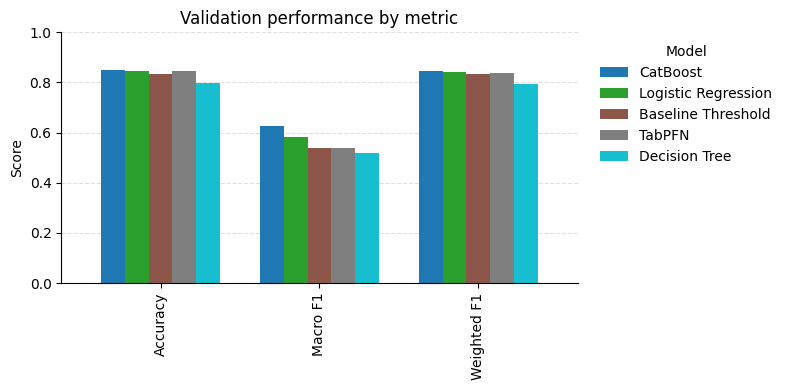

In [39]:
def _slugify_label(label):
    slug = re.sub(r"[^a-z0-9_]+", "", str(label).lower().replace(" ", "_")).strip("_")
    return slug or "class"


def build_metrics_row(model_name, y_true, y_pred, class_labels):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred).squeeze()
    class_labels = [cls for cls in class_labels if cls in set(y_true_arr)]

    metrics_row = {
        "model": model_name,
        "accuracy": accuracy_score(y_true_arr, y_pred_arr),
        "macro_f1": f1_score(y_true_arr, y_pred_arr, average="macro"),
        "weighted_f1": f1_score(y_true_arr, y_pred_arr, average="weighted"),
    }

    report = classification_report(
        y_true_arr,
        y_pred_arr,
        labels=class_labels,
        output_dict=True,
        zero_division=0,
    )
    for cls in class_labels:
        class_key = _slugify_label(cls)
        metrics_row[f"f1_{class_key}"] = report[str(cls)]["f1-score"]
        true_mask = y_true_arr == cls
        per_class_acc = (y_pred_arr == cls) == true_mask
        metrics_row[f"accuracy_{class_key}"] = float(np.mean(per_class_acc))

    return metrics_row


model_registry = {
    "CatBoost": catboost_model,
    "Logistic Regression": logreg_model,
    "Decision Tree": decision_tree_model,
    "Baseline Threshold": baseline_model,
}
if USE_TABPFN and tabpfn_model is not None:
    model_registry["TabPFN"] = tabpfn_model
if USE_AUTOGLUON and autogluon_model is not None:
    model_registry["AutoGluon"] = autogluon_model

metrics_rows = []
for name, model_candidate in model_registry.items():
    pred = np.asarray(model_candidate.predict(X_valid)).squeeze()
    class_labels = classes
    if class_labels is None:
        class_labels = getattr(model_candidate, "class_labels", np.unique(y_valid))
    metrics_rows.append(
        build_metrics_row(name, y_valid, pred, class_labels)
    )

metrics_df = (
    pd.DataFrame(metrics_rows)
    .set_index("model")
    .sort_values("macro_f1", ascending=False)
)

metrics_dir = Path("metrics")
metrics_dir.mkdir(parents=True, exist_ok=True)
for model_name, row in metrics_df.iterrows():
    slug = _slugify_label(model_name)
    metrics_path = metrics_dir / f"iclr{EVAL_YEAR}_validation_{slug}.json"
    payload = {
        "model": model_name,
        "eval_year": int(EVAL_YEAR),
        "split": "validation",
        **{metric: float(value) for metric, value in row.items()},
    }
    with metrics_path.open("w", encoding="utf-8") as handle:
        json.dump(payload, handle, indent=2)

display(metrics_df.style.format("{:.3f}"))

metrics_plot = metrics_df[["accuracy", "macro_f1", "weighted_f1"]].rename(
    columns={
        "accuracy": "Accuracy",
        "macro_f1": "Macro F1",
        "weighted_f1": "Weighted F1",
    }
)

ax = metrics_plot.T.plot(
    kind="bar",
    figsize=(8, 4),
    width=0.75,
    colormap="tab10",
)
ax.set_title("Validation performance by metric")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

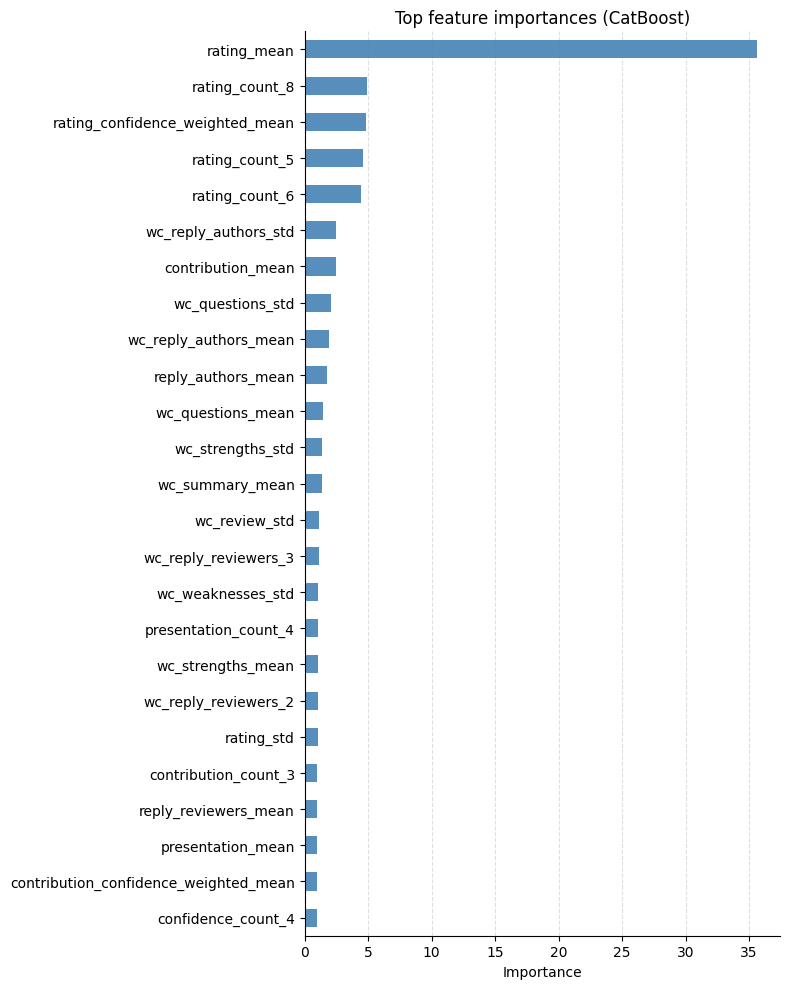

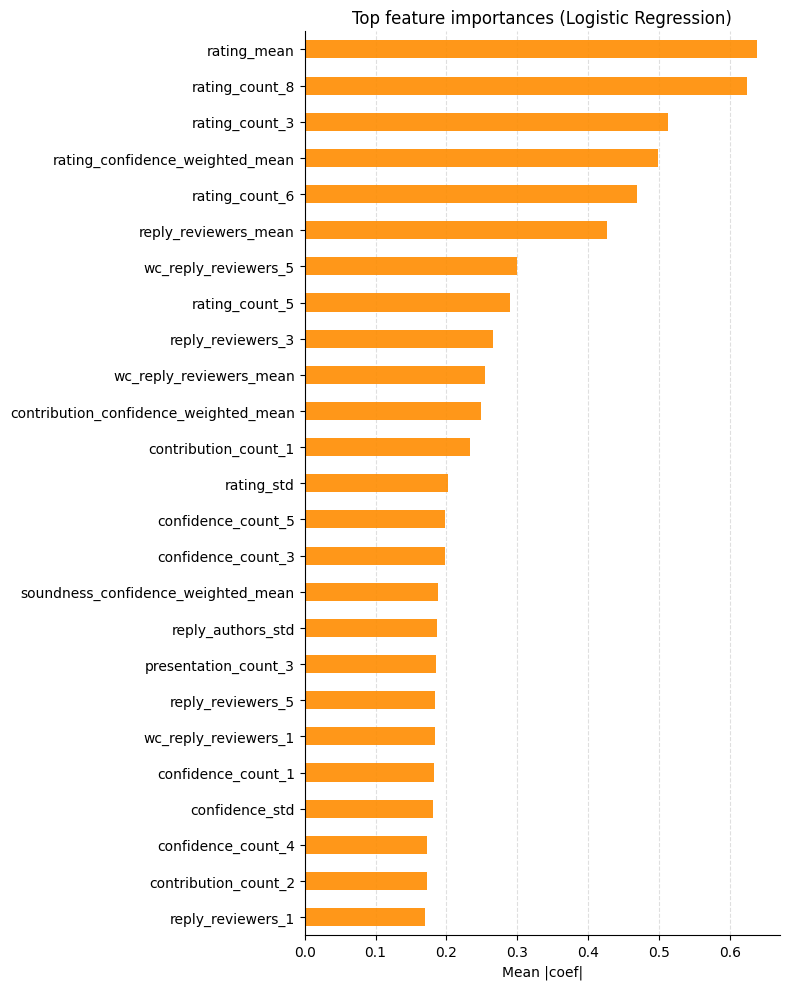

In [40]:
import matplotlib.pyplot as plt

feature_importance = pd.Series(
    catboost_model.get_feature_importance(),
    index=X_train_full.columns,
).sort_values(ascending=True)

TOP_N = 25
fig, ax = plt.subplots(figsize=(8, 10))
feature_importance.tail(TOP_N).plot(kind="barh", ax=ax, color="steelblue", alpha=0.9)
ax.set_title("Top feature importances (CatBoost)")
ax.set_xlabel("Importance")
ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

logreg_estimator = logreg_model.named_steps["logisticregression"]
logreg_coef = np.asarray(logreg_estimator.coef_)
if logreg_coef.ndim == 2:
    logreg_importance = np.mean(np.abs(logreg_coef), axis=0)
else:
    logreg_importance = np.abs(logreg_coef)

logreg_importance = pd.Series(
    logreg_importance,
    index=X_train_full.columns,
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 10))
logreg_importance.tail(TOP_N).plot(kind="barh", ax=ax, color="darkorange", alpha=0.9)
ax.set_title("Top feature importances (Logistic Regression)")
ax.set_xlabel("Mean |coef|")
ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

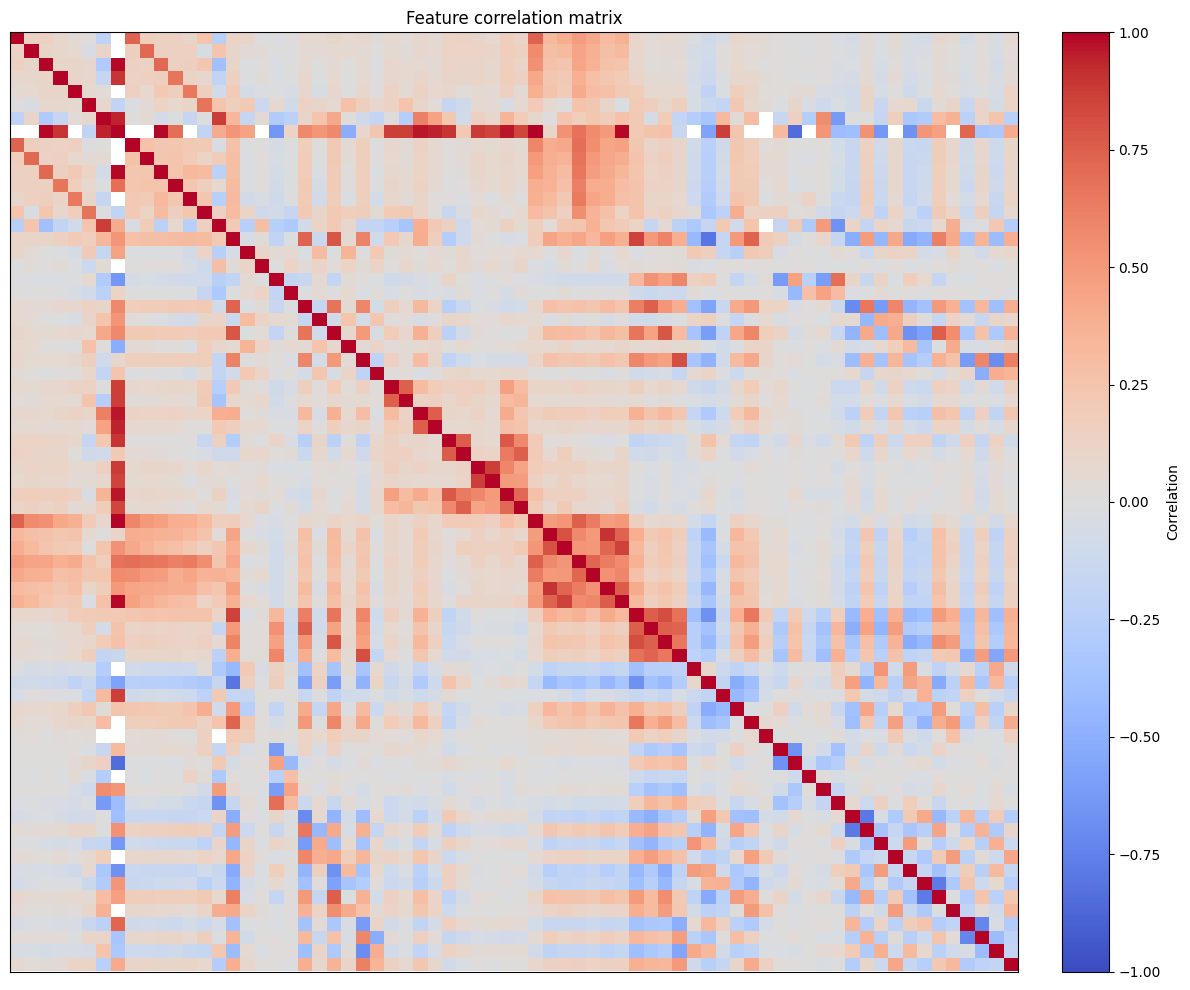

In [41]:
corr_matrix = X_train_full.corr()

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(
    corr_matrix,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax.set_title("Feature correlation matrix")
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Correlation")
plt.tight_layout()
plt.show()

In [42]:
X_eval.head()

,wc_reply_reviewers_1,wc_reply_reviewers_2,wc_reply_reviewers_3,wc_reply_reviewers_4,wc_reply_reviewers_5,wc_reply_reviewers_6,wc_reply_reviewers_7,wc_reply_reviewers_8,reply_reviewers_1,reply_reviewers_2,reply_reviewers_3,reply_reviewers_4,reply_reviewers_5,reply_reviewers_6,reply_reviewers_7,rating_mean,rating_std,rating_count,confidence_mean,confidence_std,soundness_mean,soundness_std,contribution_mean,contribution_std,presentation_mean,presentation_std,wc_summary_mean,wc_summary_std,wc_strengths_mean,wc_strengths_std,wc_weaknesses_mean,wc_weaknesses_std,wc_questions_mean,wc_questions_std,wc_review_mean,wc_review_std,wc_reply_reviewers_mean,wc_reply_authors_mean,wc_reply_authors_std,reply_reviewers_mean,reply_reviewers_std,reply_authors_mean,reply_authors_std,rating_confidence_weighted_mean,soundness_confidence_weighted_mean,contribution_confidence_weighted_mean,presentation_confidence_weighted_mean,rating_count_1,rating_count_3,rating_count_5,rating_count_6,rating_count_8,rating_count_10,confidence_count_3,confidence_count_4,confidence_count_1,confidence_count_2,confidence_count_5,soundness_count_2,soundness_count_3,soundness_count_1,soundness_count_4,contribution_count_1,contribution_count_2,contribution_count_3,contribution_count_4,presentation_count_2,presentation_count_3,presentation_count_1,presentation_count_4
0,219.0,39.0,137.0,22.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0,NaN,NaN,NaN,7.50,0.866025,4,3.75,0.433013,3.25,0.829156,3.25,0.433013,2.75,0.433013,102.75,49.393193,76.0,46.254729,191.25,101.047947,173.75,150.152214,543.75,315.464241,104.25,692.25,172.841510,1.25,0.433013,3.00,0.707107,28.00,12.00,12.25,10.25,0.0,0.00,0.00,0.25,0.75,0.0,0.25,0.75,0.0,0.0,0.00,0.25,0.25,0.0,0.5,0.0,0.0,0.75,0.25,0.25,0.75,0.00,0.0
1,0.0,0.0,49.0,19.0,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,NaN,NaN,NaN,4.25,1.299038,4,4.00,0.707107,2.75,0.433013,2.75,0.829156,2.75,0.433013,111.25,28.525208,107.5,51.853158,250.50,81.137229,165.50,82.378699,634.75,56.556940,17.00,716.00,14.422205,0.50,0.500000,1.00,0.000000,16.75,11.00,11.25,11.00,0.0,0.50,0.25,0.25,0.00,0.0,0.25,0.50,0.0,0.0,0.25,0.25,0.75,0.0,0.0,0.0,0.5,0.25,0.25,0.25,0.75,0.00,0.0
2,141.0,180.0,169.0,256.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,4.50,0.866025,4,3.25,0.433013,2.25,0.433013,2.50,0.500000,2.25,0.829156,58.75,16.902293,66.5,25.064916,179.50,52.566624,76.75,45.713100,381.50,90.513811,186.50,1229.25,146.808336,1.00,0.000000,3.75,0.433013,14.75,7.25,8.00,7.50,0.0,0.25,0.75,0.00,0.00,0.0,0.75,0.25,0.0,0.0,0.00,0.75,0.25,0.0,0.0,0.0,0.5,0.50,0.00,0.25,0.50,0.25,0.0
3,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,6.80,0.979796,5,3.60,0.800000,2.60,0.489898,2.80,0.748331,2.40,0.489898,122.40,52.905954,84.2,45.984345,380.40,184.749127,103.40,58.803401,690.40,294.118752,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,25.20,9.00,10.00,8.60,0.0,0.00,0.00,0.60,0.40,0.0,0.60,0.20,0.0,0.0,0.20,0.40,0.60,0.0,0.0,0.0,0.4,0.40,0.20,0.60,0.40,0.00,0.0
4,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,4.80,1.833030,5,3.80,0.400000,2.40,0.489898,2.40,0.489898,3.00,0.000000,93.60,19.438107,73.2,29.362561,172.40,134.164973,211.20,223.810992,550.40,161.690569,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,18.20,9.00,9.20,11.40,0.0,0.40,0.40,0.00,0.20,0.0,0.20,0.80,0.0,0.0,0.00,0.60,0.40,0.0,0.0,0.0,0.6,0.40,0.00,0.00,1.00,0.00,0.0


In [43]:
def upward_shift_with_target_mean_df(
    df,
    scores,
    cols,
    delta_mean=0.5,
    alpha_max=1.0,
):
    """
    Row-wise upward mass shift such that each row's expected score
    increases by delta_mean.

    Returns:
        shifted_df, alphas (per-row)
    """

    P = df[cols].values                      # shape (N, K)
    steps = scores[1:] - scores[:-1]         # shape (K-1,)

    # Expected step size per row
    expected_step = P[:, :-1] @ steps        # shape (N,)

    # Solve for alpha per row
    alpha = delta_mean / expected_step
    alpha = np.clip(alpha, 0.0, alpha_max)

    # Apply deterministic upward shift
    P_new = P.copy()

    for j in range(len(scores) - 1, 0, -1):
        P_new[:, j] = (1 - alpha) * P[:, j] + alpha * P[:, j - 1]

    P_new[:, 0] = (1 - alpha) * P[:, 0]

    shifted_df = df.copy()
    shifted_df[cols] = P_new

    return shifted_df, alpha


In [44]:
if EVAL_YEAR == 2026:
    # Adjust 2026 ratings for reduced review response time similar to adjustment of previous years
    score_increase = 0.6
    score_increase_2 = 0.3

    X_eval["soundness_mean"] += score_increase_2
    X_eval["confidence_mean"] += score_increase_2
    X_eval["contribution_mean"] += score_increase_2
    X_eval["presentation_mean"] += score_increase_2

    if "rating_mean" in X_eval.columns:
        X_eval["rating_mean"] += score_increase

    scores = np.array([1, 3, 5, 6, 8])
    X_eval, alpha = upward_shift_with_target_mean_df(
        X_eval,
        scores=scores,
        cols=[f"rating_count_{s}" for s in scores],
        delta_mean=score_increase,
    )
    
    scores = np.array([1,2,3,4])
    X_eval, _ = upward_shift_with_target_mean_df(
        X_eval,
        scores=scores,
        cols=[f"soundness_count_{s}" for s in scores],
        delta_mean=score_increase_2,
    )
    X_eval, _ = upward_shift_with_target_mean_df(
        X_eval,
        scores=scores,
        cols=[f"confidence_count_{s}" for s in scores],
        delta_mean=score_increase_2,
    )
    X_eval, _ = upward_shift_with_target_mean_df(
        X_eval,
        scores=scores,
        cols=[f"contribution_count_{s}" for s in scores],
        delta_mean=score_increase_2,
    )
    X_eval, _ = upward_shift_with_target_mean_df(
        X_eval,
        scores=scores,
        cols=[f"presentation_count_{s}" for s in scores],
        delta_mean=score_increase_2,
    )

eval_ids = ids_by_year.get(EVAL_YEAR)
use_submission_number = X_eval.index.name == "submission_number"
class_order = None

eval_results_by_model = {}
eval_summary_rows = []
eval_metrics_rows = []
eval_predictions = {}

for model_name, model_obj in model_registry.items():
    eval_proba_raw = model_obj.predict_proba(X_eval)
    if isinstance(eval_proba_raw, pd.DataFrame):
        eval_proba = eval_proba_raw.reindex(columns=classes).to_numpy()
    else:
        eval_proba = np.asarray(eval_proba_raw)

    eval_labels = np.asarray(classes)[np.argmax(eval_proba, axis=1)]
    eval_predictions[model_name] = {
        "labels": eval_labels,
        "proba": eval_proba,
    }

    if class_order is None:
        class_order = list(classes)

    results_eval = pd.DataFrame(
        {
            "submission_number" if use_submission_number else "id": (
                eval_ids if eval_ids is not None else X_eval.index
            ),
            "pred_status": eval_labels,
        }
    )

    for i, class_name in enumerate(classes):
        results_eval[f"proba_{class_name}"] = eval_proba[:, i]

    model_slug = model_name.lower().replace(" ", "_")
    results_eval.to_csv(
        PREDICTIONS_DIR / f"iclr{EVAL_YEAR}_{model_slug}_predictions.csv",
        index=False,
    )
    eval_results_by_model[model_name] = results_eval

    pred_counts = (
        results_eval["pred_status"]
        .value_counts()
        .reindex(classes, fill_value=0)
    )
    pred_dist = (pred_counts / pred_counts.sum()).rename("share")
    for cls_name, count in pred_counts.items():
        eval_summary_rows.append(
            {
                "model": model_name,
                "class": cls_name,
                "count": int(count),
                "share": float(pred_dist.loc[cls_name]),
            }
        )

    if EVAL_YEAR != 2026 and y_eval is not None:
        eval_mask = y_eval.notna()
        if eval_mask.any():
            eval_pred = pd.Series(eval_labels, index=X_eval.index)[eval_mask]
            print(f"ICLR {EVAL_YEAR} eval ({model_name}):")
            print(
                classification_report(
                    y_eval[eval_mask],
                    eval_pred,
                )
            )

            eval_row = build_metrics_row(
                model_name,
                y_eval[eval_mask],
                eval_pred,
                classes,
            )
            eval_metrics_rows.append(eval_row)

            eval_slug = _slugify_label(model_name)
            eval_metrics_path = metrics_dir / f"iclr{EVAL_YEAR}_eval_{eval_slug}.json"
            eval_payload = {
                "model": model_name,
                "eval_year": int(EVAL_YEAR),
                "split": "eval",
                **{
                    metric: float(value)
                    for metric, value in eval_row.items()
                    if metric != "model"
                },
            }
            with eval_metrics_path.open("w", encoding="utf-8") as handle:
                json.dump(eval_payload, handle, indent=2)


if eval_metrics_rows:
    eval_metrics_df = (
        pd.DataFrame(eval_metrics_rows)
        .set_index("model")
        .sort_values("macro_f1", ascending=False)
    )
    display(eval_metrics_df.style.format("{:.3f}"))


eval_summary_df = pd.DataFrame(eval_summary_rows)
eval_summary_df.to_csv(
    PREDICTIONS_DIR / f"iclr{EVAL_YEAR}_prediction_summary_by_model.csv",
    index=False,
)

ICLR 2025 eval (CatBoost):
              precision    recall  f1-score   support

        oral       0.94      0.15      0.25       213
      poster       0.77      0.84      0.80      3111
      reject       0.94      0.93      0.93      7973
   spotlight       0.58      0.61      0.60       380

    accuracy                           0.88     11677
   macro avg       0.81      0.63      0.65     11677
weighted avg       0.88      0.88      0.87     11677

ICLR 2025 eval (Logistic Regression):
              precision    recall  f1-score   support

        oral       0.88      0.18      0.30       213
      poster       0.77      0.82      0.79      3111
      reject       0.93      0.93      0.93      7973
   spotlight       0.51      0.51      0.51       380

    accuracy                           0.87     11677
   macro avg       0.78      0.61      0.63     11677
weighted avg       0.88      0.87      0.87     11677

ICLR 2025 eval (Decision Tree):
              precision    recall

,accuracy,macro_f1,weighted_f1,f1_oral,accuracy_oral,f1_poster,accuracy_poster,f1_reject,accuracy_reject,f1_spotlight,accuracy_spotlight
model,,,,,,,,,,,
CatBoost,0.878,0.646,0.875,0.252,0.984,0.803,0.890,0.932,0.908,0.596,0.973
Logistic Regression,0.874,0.633,0.871,0.297,0.985,0.795,0.887,0.933,0.909,0.509,0.968
Baseline Threshold,0.874,0.618,0.871,0.011,0.970,0.788,0.892,0.932,0.907,0.740,0.979
TabPFN,0.879,0.618,0.873,0.179,0.984,0.803,0.893,0.934,0.910,0.555,0.971
Decision Tree,0.798,0.534,0.800,0.267,0.979,0.644,0.814,0.897,0.860,0.328,0.942


model,Baseline Threshold,CatBoost,Decision Tree,Logistic Regression,TabPFN
class,,,,,
oral,0.012,0.003,0.010,0.004,0.002
poster,0.244,0.291,0.256,0.284,0.276
reject,0.695,0.673,0.681,0.680,0.690
spotlight,0.050,0.034,0.054,0.032,0.032


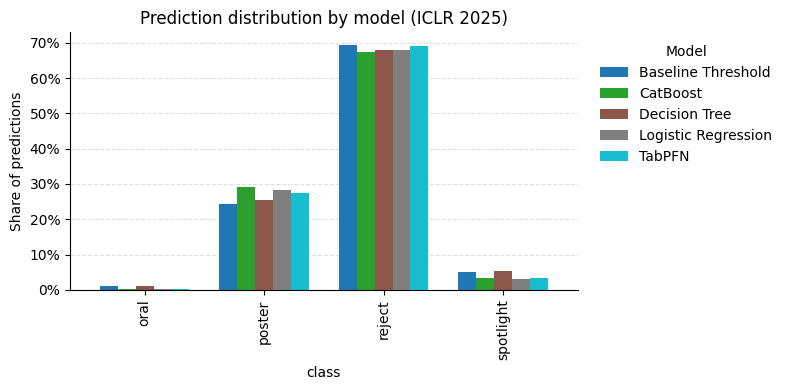

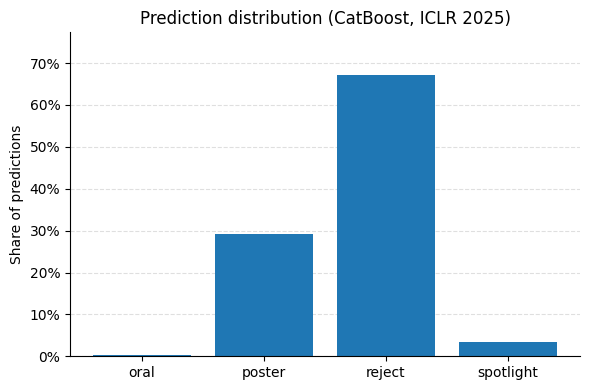

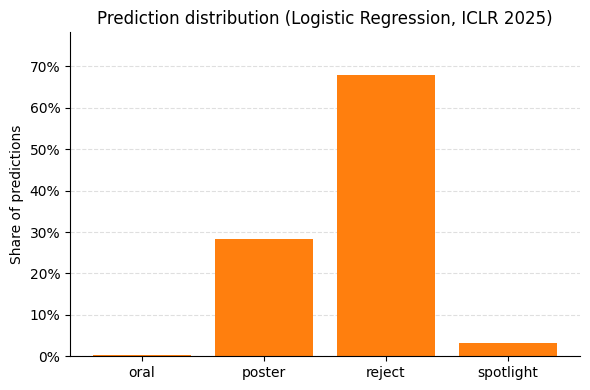

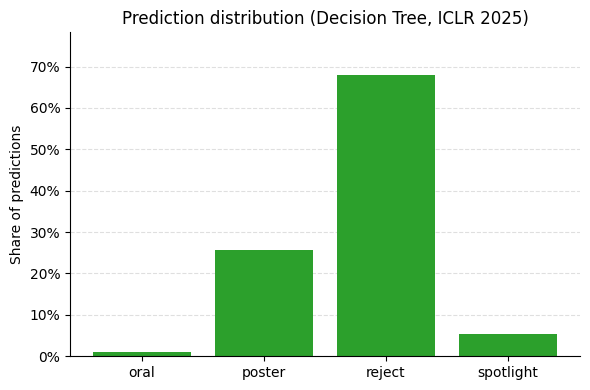

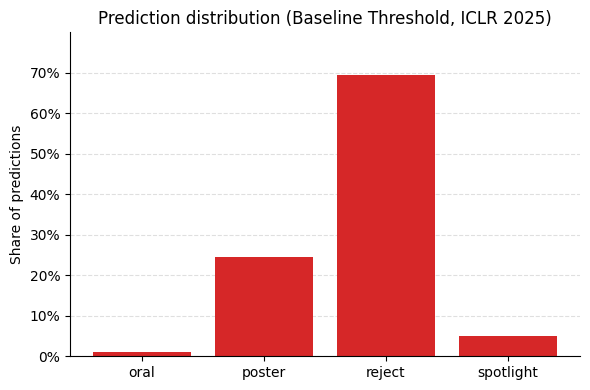

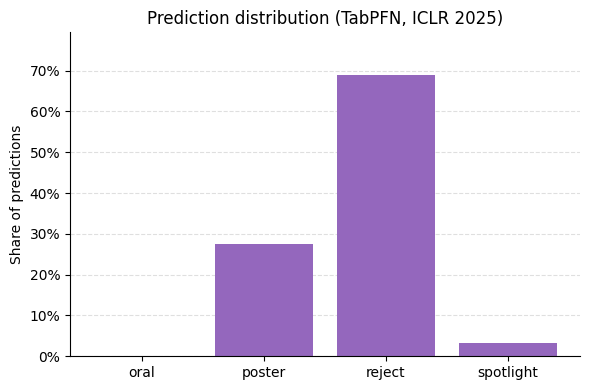

In [45]:
class_order = class_order or sorted(eval_summary_df["class"].unique())

summary_pivot = (
    eval_summary_df
    .pivot(index="class", columns="model", values="share")
    .reindex(class_order)
    .fillna(0)
)

display(summary_pivot.style.format("{:.3f}"))

# Combined visualization (grouped by class, colored by model)
ax = summary_pivot.plot(
    kind="bar",
    figsize=(8, 4),
    width=0.75,
    colormap="tab10",
)
ax.set_title(f"Prediction distribution by model (ICLR {EVAL_YEAR})")
ax.set_ylabel("Share of predictions")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

# Individual model visualizations
colors = plt.get_cmap("tab10").colors
for idx, (model_name, results_eval) in enumerate(eval_results_by_model.items()):
    pred_counts = (
        results_eval["pred_status"]
        .value_counts()
        .reindex(class_order, fill_value=0)
    )
    pred_dist = (pred_counts / pred_counts.sum()).rename("share")

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(class_order, pred_dist.values, color=colors[idx % len(colors)])
    ax.set_ylabel("Share of predictions")
    ax.set_title(f"Prediction distribution ({model_name}, ICLR {EVAL_YEAR})")
    ax.set_ylim(0, pred_dist.max() * 1.15)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.set_axisbelow(True)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    plt.show()
